**Data and Variables**

In [31]:
#Python libraries needed for project
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from decimal import Decimal
#import plotly.express as px
#import plotly.graph_objects as go
#from plotly.subplots import make_subplots
from scipy import stats
from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima
from math import sqrt
import matplotlib.dates as mdates
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
from tabulate import tabulate
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.metrics import r2_score
from datetime import datetime
import ctypes
import warnings 
warnings.filterwarnings('ignore')
from docx import Document
from itertools import combinations
from sklearn.model_selection import cross_val_score

*Data Acquisition:*

In [32]:
#Read in 10 csv files, one for each year (2012 to 2022) into 10 data frames from Github. 
df_FY2012 = pd.read_csv("https://raw.githubusercontent.com/Data-Vlad/Data-Science/refs/heads/main/Data%20698%20-%20Capstone%20Project/FY2012.csv")
df_FY2013 = pd.read_csv("https://raw.githubusercontent.com/Data-Vlad/Data-Science/refs/heads/main/Data%20698%20-%20Capstone%20Project/FY2013.csv")
df_FY2014 = pd.read_csv("https://raw.githubusercontent.com/Data-Vlad/Data-Science/refs/heads/main/Data%20698%20-%20Capstone%20Project/FY2014.csv")
df_FY2015 = pd.read_csv("https://raw.githubusercontent.com/Data-Vlad/Data-Science/refs/heads/main/Data%20698%20-%20Capstone%20Project/FY2015.csv")
df_FY2016 = pd.read_csv("https://raw.githubusercontent.com/Data-Vlad/Data-Science/refs/heads/main/Data%20698%20-%20Capstone%20Project/FY2016.csv")
df_FY2017 = pd.read_csv("https://raw.githubusercontent.com/Data-Vlad/Data-Science/refs/heads/main/Data%20698%20-%20Capstone%20Project/FY2017.csv")
df_FY2018 = pd.read_csv("https://raw.githubusercontent.com/Data-Vlad/Data-Science/refs/heads/main/Data%20698%20-%20Capstone%20Project/FY2018.csv")
df_FY2019 = pd.read_csv("https://raw.githubusercontent.com/Data-Vlad/Data-Science/refs/heads/main/Data%20698%20-%20Capstone%20Project/FY2019.csv")
df_FY2020 = pd.read_csv("https://raw.githubusercontent.com/Data-Vlad/Data-Science/refs/heads/main/Data%20698%20-%20Capstone%20Project/FY2020.csv")
df_FY2021 = pd.read_csv("https://raw.githubusercontent.com/Data-Vlad/Data-Science/refs/heads/main/Data%20698%20-%20Capstone%20Project/FY2021.csv")
df_FY2022 = pd.read_csv("https://raw.githubusercontent.com/Data-Vlad/Data-Science/refs/heads/main/Data%20698%20-%20Capstone%20Project/FY2022.csv")


*Data Integration:*

In [33]:
#Combining all 10 data frames into one data frame: "df_FY_ALL", to allow for time series analysis
dfs = [df_FY2012,df_FY2013,df_FY2014,df_FY2015,df_FY2016,df_FY2017,df_FY2018,df_FY2019,df_FY2020,df_FY2021,df_FY2022]
for df in dfs[1:]:
     df.columns = dfs[0].columns
df_FY_All = pd.concat([df_FY2012,df_FY2013,df_FY2014,df_FY2015,df_FY2016,df_FY2017,df_FY2018,df_FY2019,df_FY2020,df_FY2021,df_FY2022],axis=0,ignore_index=True)

*Data Cleaning:*

In [34]:

#Renaming column names for better clarity
for i, col in enumerate(df_FY_All.columns):
    if('.' in col):
       df_FY_All.rename(columns={col:col.split('.', 1)[1]}, inplace=True)

df_FY_All =  df_FY_All.rename(columns={'institution name': 'institution_name'})
df_FY_All =  df_FY_All.rename(columns={'Tuition and fees, after deducting discounts and allowances': 'Tuition_and_Fees'})
df_FY_All =  df_FY_All.rename(columns={'Student services - Current year total': 'Student_services'})
df_FY_All =  df_FY_All.rename(columns={'Full-time retention rate, 2012': 'Fulltime_retention_rate'})
df_FY_All =  df_FY_All.rename(columns={'Graduation rate - bachelor\'s degree within 4 years, total': 'Four_year_graduation_rate'})
df_FY_All =  df_FY_All.rename(columns={'Instruction - Current year total': 'Instruction'})
df_FY_All =  df_FY_All.rename(columns={'Research - Current year total': 'Research'})
df_FY_All =  df_FY_All.rename(columns={'Academic support - Current year total': 'Academic_support'})
df_FY_All =  df_FY_All.rename(columns={'Scholarships and fellowships expenses -- Current year total': 'Scholarships_and_Fellowships'})

#Changing the "year" column data type for data accuracy and consistency
for col in df_FY_All.columns:
    df_FY_All['year'] = pd.to_datetime(df_FY_All['year'], format='%Y')
df_FY_All ['year'] = df_FY_All ['year'].dt.year

 #Checking for missing values to ensure data quality and model accuracy  
missing_values = df_FY_All.isnull().sum()

#Upon checking for missing values, none were found
df_FY_All= df_FY_All.dropna(axis=1)

*Feature Engineering:*

Rolling up multiple columns with related information into one single column in order to simplify data for analysis and reduce dimensionality for better ML model performance

In [35]:
#Rolling up all revenue stream fields relating to grants and contracts
df_FY_All = df_FY_All.assign(Grants_and_Contracts=lambda x:df_FY_All['Federal operating grants and contracts'] + df_FY_All['State operating grants and contracts'] + df_FY_All['Local/private operating grants and contracts'] + df_FY_All['Federal nonoperating grants'] + df_FY_All['State nonoperating grants'] + df_FY_All['Local nonoperating grants'])
#Rolling up all revenue stream fields relation to appropriations
df_FY_All = df_FY_All.assign(Appropriations=lambda x:df_FY_All['Federal appropriations'] + df_FY_All['State appropriations'] + df_FY_All['Local appropriations, education district taxes, and similar support'])
#Rolling up all revenue stream fields relating to sales and services
df_FY_All = df_FY_All.assign(Sales_and_Services=lambda x:df_FY_All['Sales and services of auxiliary enterprises'] + df_FY_All['Sales and services of educational activities']) 
#Rolling up all funding allocation fields relating to Academic Programs
df_FY_All = df_FY_All.assign(Academic_programs=lambda x:df_FY_All['Instruction'] + df_FY_All['Research'] + df_FY_All['Academic_support'] + df_FY_All['Scholarships_and_Fellowships'] )

**Revenue Stream Composition by College**

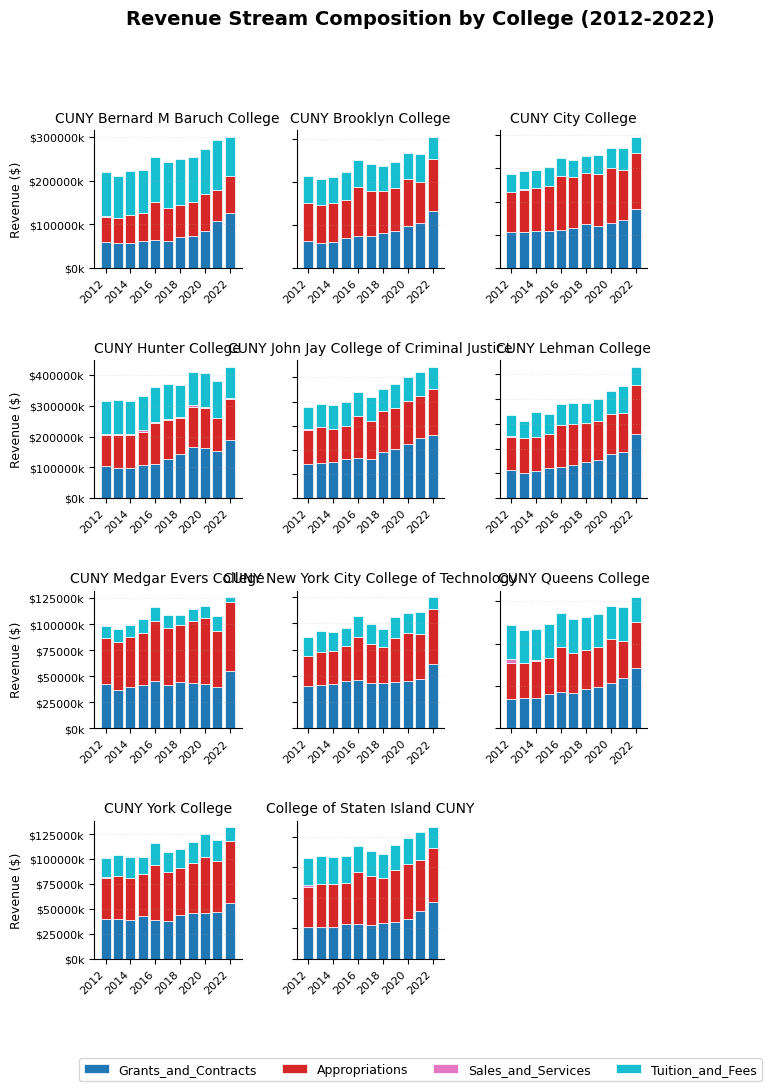

In [36]:
#transform the data frame for analysis
revenue_stream_df= df_FY_All.groupby(['institution_name', 'year'])[['Grants_and_Contracts','Appropriations','Sales_and_Services','Tuition_and_Fees']].sum().reset_index()  
# Identify unique values in each column (assuming first column is college a'Grants_and_Contracts','Appropriations','Sales_and_Services','Tuition_and_Fees'nd second is year)
colleges = revenue_stream_df.iloc[:, 0].unique()
years = revenue_stream_df.iloc[:, 1].unique()
# Assume remaining columns are revenue streams
revenue_streams = revenue_stream_df.columns[2:].tolist()
    # Transform data for analysis 
    # Create a 3D numpy array from the revenue_stream_df DataFrame
data = np.zeros((len(colleges), len(years), len(revenue_streams)))
for i, college in enumerate(colleges):
        for j, year in enumerate(years):
            for k, stream in enumerate(revenue_streams):
                value = revenue_stream_df[(revenue_stream_df.iloc[:, 0] == college) & (revenue_stream_df.iloc[:, 1] == year)][stream]
                if not value.empty:
                   data[i, j, k] = value.values[0]
   # Create subplots
fig, axs = plt.subplots(4, 3, figsize=(8.5, 11))  # Full page, standard paper size
axs = axs.ravel()  # Flatten the array to make indexing easier
# Colorful color map
colors = plt.cm.tab10(np.linspace(0, 1, len(revenue_streams)))
for i, college in enumerate(colleges):
    if i < len(axs):  # Ensure we don't exceed the number of subplots
        ax = axs[i]
        bottom = np.zeros(len(years))
        for j, stream in enumerate(revenue_streams):
            values = data[i, :, j]
            ax.bar(years, values, bottom=bottom, label=stream, color=colors[j], edgecolor='white', linewidth=0.5)
            bottom += values
        ax.set_title(f'{college}', fontsize=10)
        ax.tick_params(axis='both', which='major', labelsize=8)
        # Show years with 2-year intervals
        ax.set_xticks(years[::2])
        ax.set_xticklabels(years[::2], rotation=45, ha='right')
        # Format y-axis labels to be more compact
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}k'))
        # Remove y-axis labels for non-leftmost subplots
        if i % 3 != 0:
            ax.set_yticklabels([])
        else:
            ax.set_ylabel('Revenue ($)', fontsize=9)
        # Remove top and right spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        # Add subtle gridlines
        ax.grid(True, axis='y', linestyle=':', alpha=0.3)
# Remove any unused subplots
for i in range(len(colleges), len(axs)):
    fig.delaxes(axs[i])
# Add a common legend at the bottom
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=len(revenue_streams), 
           bbox_to_anchor=(0.5, 0), fontsize=9)
# Add overall title
fig.suptitle('Revenue Stream Composition by College (2012-2022)', fontsize=14, fontweight='bold')
plt.tight_layout()
#adjust plot
fig.subplots_adjust(hspace=0.67, wspace=0.374, left=0.116, right=0.767, bottom=0.117, top=0.87)
plt.show()

**Funding Allocation Composition by College**

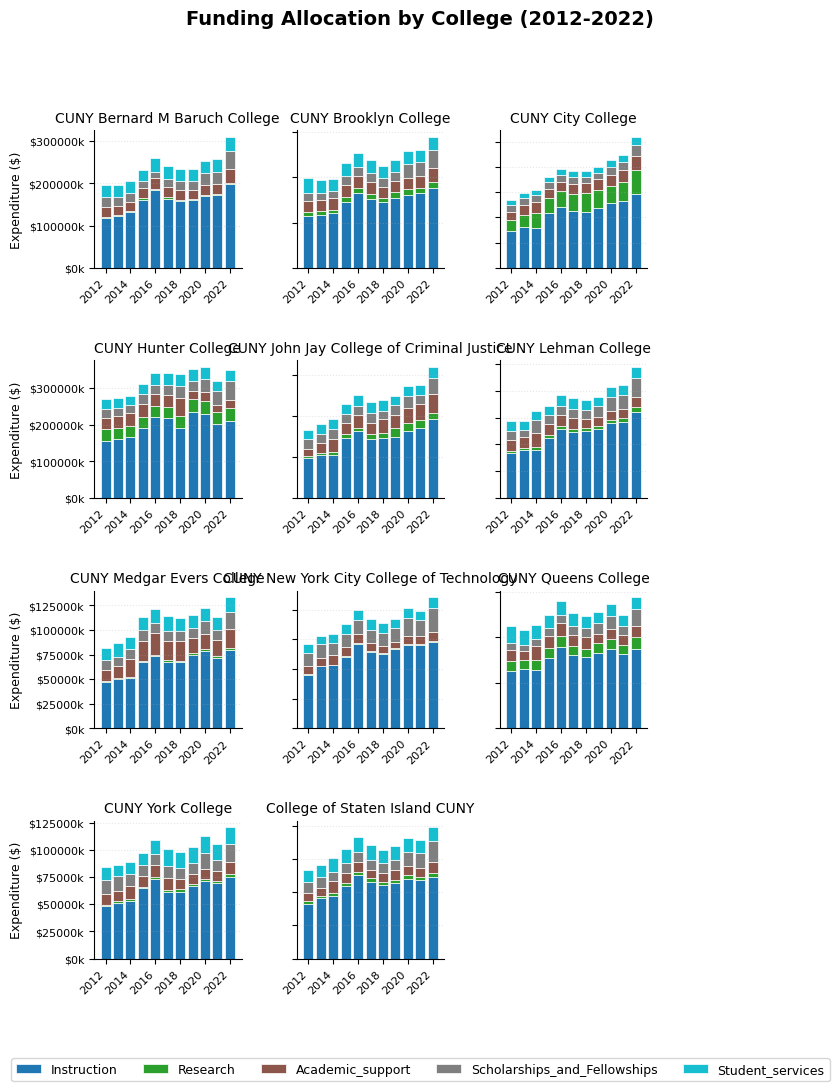

In [37]:
funding_allocation_df = df_FY_All.groupby(['institution_name', 'year'])[['Instruction','Research','Academic_support','Scholarships_and_Fellowships','Student_services']].sum().reset_index() 
# Identify unique values in each column (assuming first column is college and second is year)
colleges = funding_allocation_df.iloc[:, 0].unique()
years = funding_allocation_df.iloc[:, 1].unique()
# Assume remaining columns are revenue streams
funding_streams = funding_allocation_df.columns[2:].tolist()
    # Transform data for analysis 
    # Create a 3D numpy array from the revenue_stream_df DataFrame
data = np.zeros((len(colleges), len(years), len(funding_streams)))
for i, college in enumerate(colleges):
        for j, year in enumerate(years):
            for k, stream in enumerate(funding_streams):
                value = funding_allocation_df[(funding_allocation_df.iloc[:, 0] == college) & (funding_allocation_df.iloc[:, 1] == year)][stream]
                if not value.empty:
                   data[i, j, k] = value.values[0]
   # Create subplots
fig, axs = plt.subplots(4, 3, figsize=(8.5, 11))  # Full page, standard paper size
axs = axs.ravel()  # Flatten the array to make indexing easier
# Colorful color map
colors = plt.cm.tab10(np.linspace(0, 1, len(funding_streams)))
for i, college in enumerate(colleges):
    if i < len(axs):  # Ensure we don't exceed the number of subplots
        ax = axs[i]
        bottom = np.zeros(len(years))
        for j, stream in enumerate(funding_streams):
            values = data[i, :, j]
            ax.bar(years, values, bottom=bottom, label=stream, color=colors[j], edgecolor='white', linewidth=0.5)
            bottom += values
        ax.set_title(f'{college}', fontsize=10)
        ax.tick_params(axis='both', which='major', labelsize=8)
        # Show years with 2-year intervals
        ax.set_xticks(years[::2])
        ax.set_xticklabels(years[::2], rotation=45, ha='right')
        # Format y-axis labels to be more compact
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}k'))
        # Remove y-axis labels for non-leftmost subplots
        if i % 3 != 0:
            ax.set_yticklabels([])
        else:
            ax.set_ylabel('Expenditure ($)', fontsize=9)
        # Remove top and right spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        # Add subtle gridlines
        ax.grid(True, axis='y', linestyle=':', alpha=0.3)
# Remove any unused subplots
for i in range(len(colleges), len(axs)):
    fig.delaxes(axs[i])
# Add a common legend at the bottom
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=len(funding_streams), 
           bbox_to_anchor=(0.5, 0), fontsize=9)
# Add overall title
fig.suptitle('Funding Allocation by College (2012-2022)', fontsize=14, fontweight='bold')
plt.tight_layout()
#adjust plot
fig.subplots_adjust(hspace=0.67, wspace=0.374, left=0.116, right=0.767, bottom=0.117, top=0.87)
plt.show()


**Relationship between Revenue Streams and Retenion Rate**

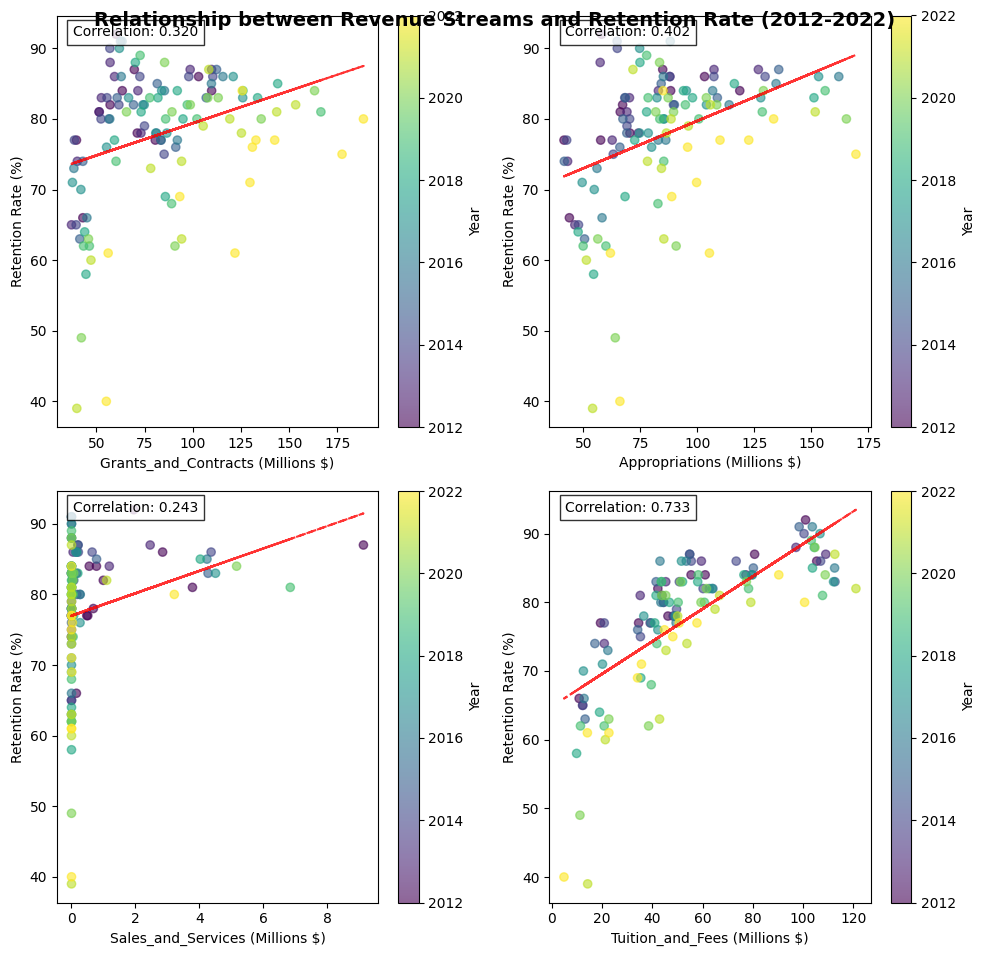

In [38]:
#data frame for Correlation analysis
correlation_df = df_FY_All[['institution_name','year','Fulltime_retention_rate','Four_year_graduation_rate','Instruction','Research','Academic_support','Scholarships_and_Fellowships','Student_services','Grants_and_Contracts','Appropriations','Sales_and_Services','Tuition_and_Fees']]
#revenue metrics and titles
revenue_retention_metrics = ['Grants_and_Contracts','Appropriations','Sales_and_Services','Tuition_and_Fees']
revenue_retention_titles = ['Grants_and_Contracts','Appropriations','Sales_and_Services','Tuition_and_Fees']
#funding allocaton metrics and titles
funding_retention_metrics = ['Instruction','Research','Academic_support','Scholarships_and_Fellowships','Student_services']
funding_retention_titles = ['Instruction','Research','Academic_support','Scholarships_and_Fellowships','Student_services']


# Relationship between Revenue Streams and Retention Rate
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle('Relationship between Revenue Streams and Retention Rate (2012-2022)',  fontsize=14, fontweight='bold', y=0.95)
for ax, metric, title in zip(axes.flat,revenue_retention_metrics, revenue_retention_titles):
    # Convert to millions for better readability
    x_values = correlation_df[metric] / 1_000_000
    
    # Create scatter plot with years as colors
    scatter = ax.scatter(x_values, correlation_df['Fulltime_retention_rate'], 
                        c=correlation_df['year'], cmap='viridis', 
                        alpha=0.6)
    # Add regression line
    z = np.polyfit(x_values, correlation_df['Fulltime_retention_rate'], 1)
    p = np.poly1d(z)
    ax.plot(x_values, p(x_values), "r--", alpha=0.8)
    ax.set_xlabel(f'{title} (Millions $)')
    ax.set_ylabel('Retention Rate (%)')
    # Calculate and display correlation coefficient
    corr = correlation_df[metric].corr(correlation_df['Fulltime_retention_rate'])
    ax.text(0.05, 0.95, f'Correlation: {corr:.3f}', 
            transform=ax.transAxes, fontsize=10,
            bbox=dict(facecolor='white', alpha=0.8))
    # Add colorbar
    plt.colorbar(scatter, ax=ax, label='Year')
plt.tight_layout()
plt.show()


**Relationship between Funding Allocations and Retenion Rate**

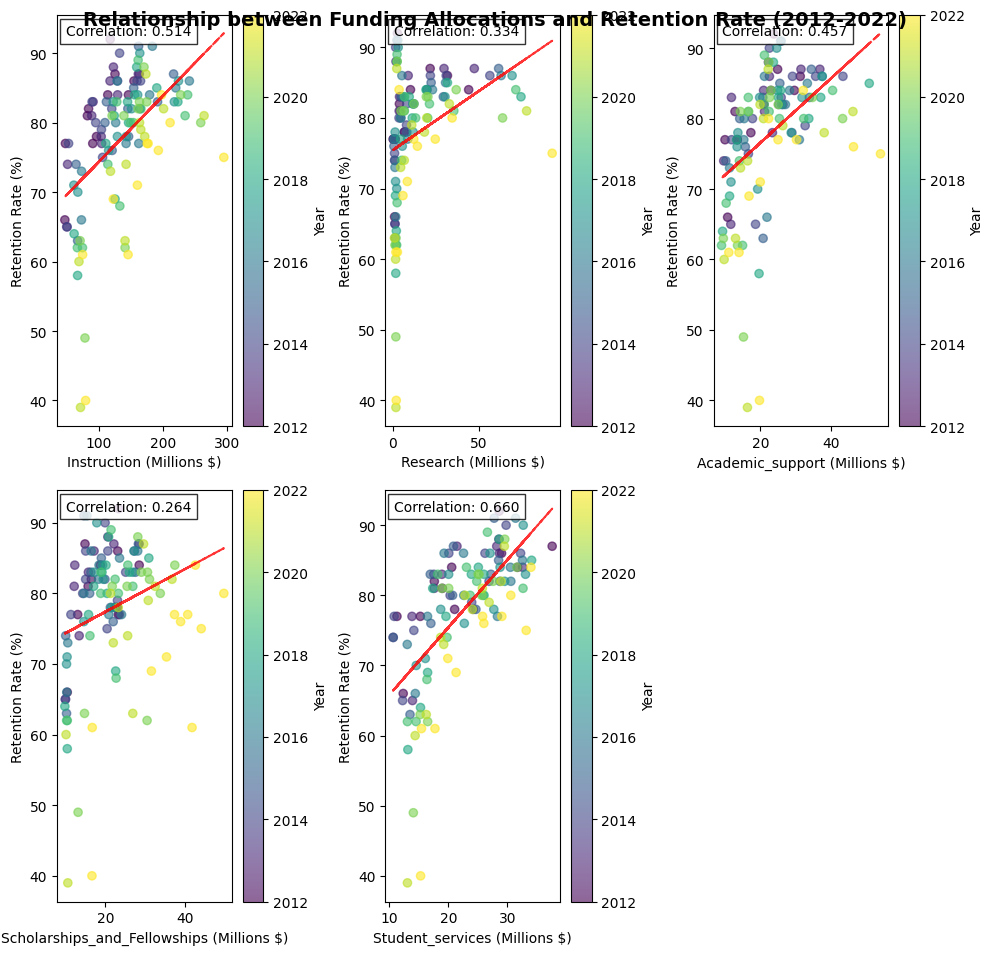

In [39]:
#data frame for Correlation analysis
correlation_df = df_FY_All[['institution_name','year','Fulltime_retention_rate','Four_year_graduation_rate','Instruction','Research','Academic_support','Scholarships_and_Fellowships','Student_services','Grants_and_Contracts','Appropriations','Sales_and_Services','Tuition_and_Fees']]
#revenue metrics and titles
revenue_retention_metrics = ['Grants_and_Contracts','Appropriations','Sales_and_Services','Tuition_and_Fees']
revenue_retention_titles = ['Grants_and_Contracts','Appropriations','Sales_and_Services','Tuition_and_Fees']
#funding allocaton metrics and titles
funding_retention_metrics = ['Instruction','Research','Academic_support','Scholarships_and_Fellowships','Student_services']
funding_retention_titles = ['Instruction','Research','Academic_support','Scholarships_and_Fellowships','Student_services']


# Relationship between Funding Allocations and Retention Rate
fig, axes = plt.subplots(2, 3, figsize=(10, 10))
fig.suptitle('Relationship between Funding Allocations and Retention Rate (2012-2022)', fontsize=14, fontweight='bold', y=0.95)
for ax, metric, title in zip(axes.flat,funding_retention_metrics, funding_retention_titles):
    # Convert to millions for better readability
    x_values = correlation_df[metric] / 1_000_000
    # Create scatter plot with years as colors
    scatter = ax.scatter(x_values, correlation_df['Fulltime_retention_rate'], 
                        c=correlation_df['year'], cmap='viridis', 
                        alpha=0.6)
    # Add regression line
    z = np.polyfit(x_values, correlation_df['Fulltime_retention_rate'], 1)
    p = np.poly1d(z)
    ax.plot(x_values, p(x_values), "r--", alpha=0.8)
    ax.set_xlabel(f'{title} (Millions $)')
    ax.set_ylabel('Retention Rate (%)')
    # Calculate and display correlation coefficient
    corr = correlation_df[metric].corr(correlation_df['Fulltime_retention_rate'])
    ax.text(0.05, 0.95, f'Correlation: {corr:.3f}', 
            transform=ax.transAxes, fontsize=10,
            bbox=dict(facecolor='white', alpha=0.8))   
    # Add colorbar
    plt.colorbar(scatter, ax=ax, label='Year')
#removes the empty subplot
axes_flat = axes.flat
axes_flat[5].axis('off')
plt.tight_layout()
plt.show()


**Relationship between Revenue Streams and Graduation Rate**

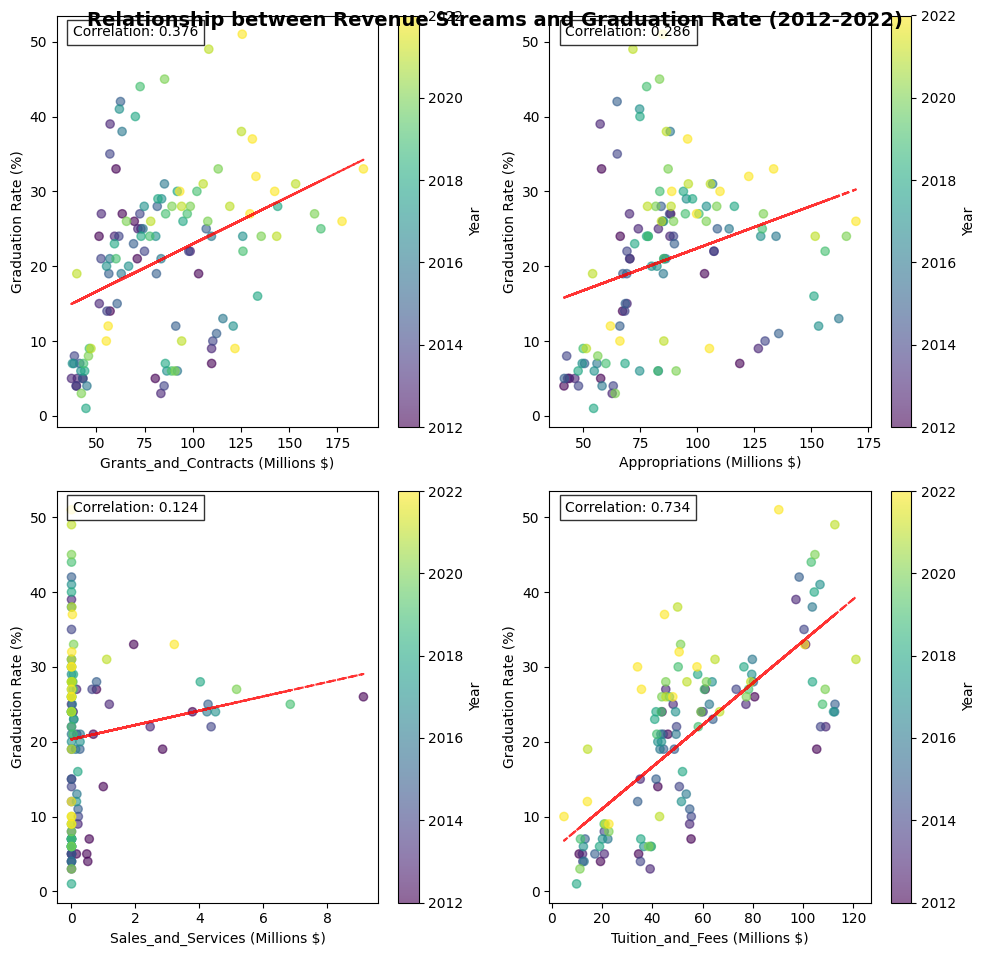

In [40]:
#data frame for Correlation analysis
correlation_df = df_FY_All[['institution_name','year','Fulltime_retention_rate','Four_year_graduation_rate','Instruction','Research','Academic_support','Scholarships_and_Fellowships','Student_services','Grants_and_Contracts','Appropriations','Sales_and_Services','Tuition_and_Fees']]
#revenue metrics and titles
revenue_retention_metrics = ['Grants_and_Contracts','Appropriations','Sales_and_Services','Tuition_and_Fees']
revenue_retention_titles = ['Grants_and_Contracts','Appropriations','Sales_and_Services','Tuition_and_Fees']
#funding allocaton metrics and titles
funding_retention_metrics = ['Instruction','Research','Academic_support','Scholarships_and_Fellowships','Student_services']
funding_retention_titles = ['Instruction','Research','Academic_support','Scholarships_and_Fellowships','Student_services']

# Relationship between Revenue Streams and Graduation Rate
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle('Relationship between Revenue Streams and Graduation Rate (2012-2022)', fontsize=14, fontweight='bold', y=0.95)
for ax, metric, title in zip(axes.flat,revenue_retention_metrics, revenue_retention_titles):
    # Convert to millions for better readability
    x_values = correlation_df[metric] / 1_000_000
    # Create scatter plot with years as colors
    scatter = ax.scatter(x_values, correlation_df['Four_year_graduation_rate'], 
                        c=correlation_df['year'], cmap='viridis', 
                        alpha=0.6)
    # Add regression line
    z = np.polyfit(x_values, correlation_df['Four_year_graduation_rate'], 1)
    p = np.poly1d(z)
    ax.plot(x_values, p(x_values), "r--", alpha=0.8)
    ax.set_xlabel(f'{title} (Millions $)')
    ax.set_ylabel('Graduation Rate (%)')
    # Calculate and display correlation coefficient
    corr = correlation_df[metric].corr(correlation_df['Four_year_graduation_rate'])
    ax.text(0.05, 0.95, f'Correlation: {corr:.3f}', 
            transform=ax.transAxes, fontsize=10,
            bbox=dict(facecolor='white', alpha=0.8))
    # Add colorbar
    plt.colorbar(scatter, ax=ax, label='Year')
plt.tight_layout()
plt.show()

**Relationship between Funding Allocations and Graduation Rate**

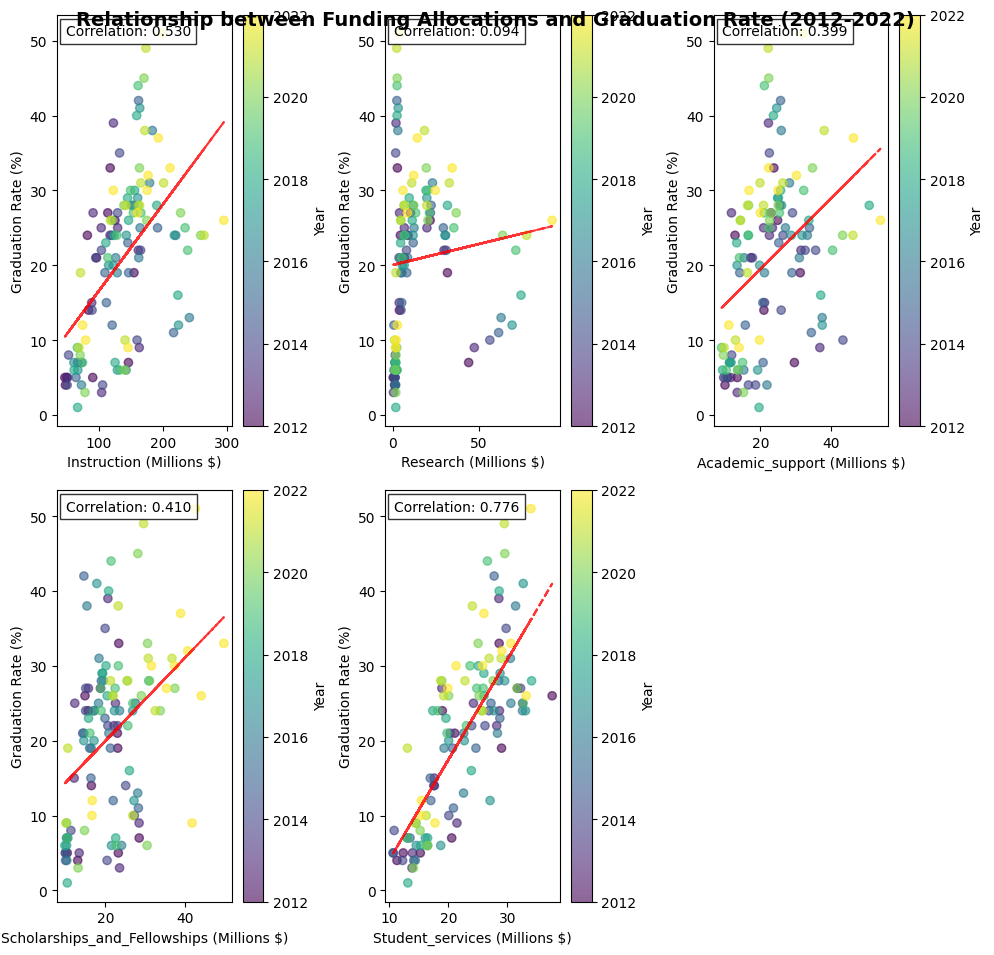

In [41]:
#data frame for Correlation analysis
correlation_df = df_FY_All[['institution_name','year','Fulltime_retention_rate','Four_year_graduation_rate','Instruction','Research','Academic_support','Scholarships_and_Fellowships','Student_services','Grants_and_Contracts','Appropriations','Sales_and_Services','Tuition_and_Fees']]
#revenue metrics and titles
revenue_retention_metrics = ['Grants_and_Contracts','Appropriations','Sales_and_Services','Tuition_and_Fees']
revenue_retention_titles = ['Grants_and_Contracts','Appropriations','Sales_and_Services','Tuition_and_Fees']
#funding allocaton metrics and titles
funding_retention_metrics = ['Instruction','Research','Academic_support','Scholarships_and_Fellowships','Student_services']
funding_retention_titles = ['Instruction','Research','Academic_support','Scholarships_and_Fellowships','Student_services']

# Relationship between Funding Allocations and Graduaton Rate
fig, axes = plt.subplots(2, 3, figsize=(10, 10))
fig.suptitle('Relationship between Funding Allocations and Graduation Rate (2012-2022)', fontsize=14, fontweight='bold', y=0.95)
for ax, metric, title in zip(axes.flat,funding_retention_metrics, funding_retention_titles):
    # Convert to millions for better readability
    x_values = correlation_df[metric] / 1_000_000
    # Create scatter plot with years as colors
    scatter = ax.scatter(x_values, correlation_df['Four_year_graduation_rate'], 
                        c=correlation_df['year'], cmap='viridis', 
                        alpha=0.6)
    # Add regression line
    z = np.polyfit(x_values, correlation_df['Four_year_graduation_rate'], 1)
    p = np.poly1d(z)
    ax.plot(x_values, p(x_values), "r--", alpha=0.8)
    ax.set_xlabel(f'{title} (Millions $)')
    ax.set_ylabel('Graduation Rate (%)')
    # Calculate and display correlation coefficient
    corr = correlation_df[metric].corr(correlation_df['Four_year_graduation_rate'])
    ax.text(0.05, 0.95, f'Correlation: {corr:.3f}', 
            transform=ax.transAxes, fontsize=10,
            bbox=dict(facecolor='white', alpha=0.8))
    # Add colorbar
    plt.colorbar(scatter, ax=ax, label='Year')
    #removes the empty subplot
axes_flat = axes.flat
axes_flat[5].axis('off')
plt.tight_layout()
plt.show()


**One-way ANOVA: Differences across Colleges**

In [42]:

#Create a data frame for ANOVA

df_anova =  df_FY_All[['institution_name','year','Grants_and_Contracts', 'Research', 'Tuition_and_Fees','Instruction', 'Appropriations', 'Academic_support','Four_year_graduation_rate','Fulltime_retention_rate','Sales_and_Services','Student_services','Scholarships_and_Fellowships']]
One_way_results_Colleges = pd.DataFrame(columns=['Measure', 'Factor', 'F-statistic', 'p-value'])                  
                    
# Function to perform one-way ANOVA
def perform_anova(df_anova , group_column, value_column):
    groups = df_anova [group_column].unique()
    group_data = [df_anova[df_anova[group_column] == group][value_column] for group in groups]
    f_value, p_value = stats.f_oneway(*group_data)
    return f_value, p_value

# Variables to analyze
revenue_vars = ['Grants_and_Contracts', 'Tuition_and_Fees', 'Appropriations']
funding_vars = ['Academic_support','Student_services','Instruction']
outcome_vars = ['Fulltime_retention_rate','Four_year_graduation_rate']

#One-way ANOVA: Differences across colleges
print("One-way ANOVA: Differences across colleges")
for var in revenue_vars + funding_vars + outcome_vars:
    f_value, p_value = perform_anova(df_anova, 'institution_name', var)
    new_row = pd.DataFrame({'Measure': [var], 'Factor': ['Colleges'], 'F-statistic': [f_value], 'p-value': [p_value]})
    One_way_results_Colleges = pd.concat([One_way_results_Colleges, new_row], ignore_index=True)


#set the index to be the first column
One_way_results_Colleges = One_way_results_Colleges.set_index("Measure")

# Format and display results
print(tabulate(One_way_results_Colleges.round(4), headers='keys', tablefmt='grid'))


One-way ANOVA: Differences across colleges
+---------------------------+----------+---------------+-----------+
| Measure                   | Factor   |   F-statistic |   p-value |
+===========================+==========+===============+===========+
| Grants_and_Contracts      | Colleges |       23.7851 |         0 |
+---------------------------+----------+---------------+-----------+
| Tuition_and_Fees          | Colleges |      502.974  |         0 |
+---------------------------+----------+---------------+-----------+
| Appropriations            | Colleges |       71.2192 |         0 |
+---------------------------+----------+---------------+-----------+
| Academic_support          | Colleges |       42.8078 |         0 |
+---------------------------+----------+---------------+-----------+
| Student_services          | Colleges |       79.168  |         0 |
+---------------------------+----------+---------------+-----------+
| Instruction               | Colleges |       42.1668 |    

**One-way ANOVA: Differences across Years**

In [43]:

df_anova =  df_FY_All[['institution_name','year','Grants_and_Contracts', 'Research', 'Tuition_and_Fees','Instruction', 'Appropriations', 'Academic_support','Four_year_graduation_rate','Fulltime_retention_rate','Sales_and_Services','Student_services','Scholarships_and_Fellowships']]

One_way_results_Years = pd.DataFrame(columns=['Measure', 'Factor', 'F-statistic', 'p-value']) 
# Function to perform one-way ANOVA
def perform_anova(df_anova , group_column, value_column):
    groups = df_anova [group_column].unique()
    group_data = [df_anova[df_anova[group_column] == group][value_column] for group in groups]
    f_value, p_value = stats.f_oneway(*group_data)
    return f_value, p_value

# Variables to analyze
revenue_vars = ['Grants_and_Contracts', 'Tuition_and_Fees', 'Appropriations']
funding_vars = ['Academic_support','Student_services','Instruction']
outcome_vars = ['Fulltime_retention_rate','Four_year_graduation_rate']

#One-way ANOVA: Differences across years
print("One-way ANOVA: Differences across years")
for var in revenue_vars + funding_vars + outcome_vars:
    f_value, p_value = perform_anova(df_anova, 'year', var)
    new_row = pd.DataFrame({'Measure': [var], 'Factor': ['Years'], 'F-statistic': [f_value], 'p-value': [p_value]})
    One_way_results_Years = pd.concat([One_way_results_Years, new_row], ignore_index=True)

    #set the index to be the first column
One_way_results_Years = One_way_results_Years.set_index("Measure")

# Format and display results
print(tabulate(One_way_results_Years.round(4), headers='keys', tablefmt='grid'))

One-way ANOVA: Differences across years
+---------------------------+----------+---------------+-----------+
| Measure                   | Factor   |   F-statistic |   p-value |
+===========================+==========+===============+===========+
| Grants_and_Contracts      | Years    |        3.5456 |    0.0004 |
+---------------------------+----------+---------------+-----------+
| Tuition_and_Fees          | Years    |        0.1538 |    0.9987 |
+---------------------------+----------+---------------+-----------+
| Appropriations            | Years    |        1.388  |    0.1951 |
+---------------------------+----------+---------------+-----------+
| Academic_support          | Years    |        0.5245 |    0.8697 |
+---------------------------+----------+---------------+-----------+
| Student_services          | Years    |        0.3401 |    0.9681 |
+---------------------------+----------+---------------+-----------+
| Instruction               | Years    |        2.1448 |    0.0

**Two-way ANOVA: Interaction between College and Year Outcomes**

In [44]:
#Create a data frame for ANOVA

df_anova =  df_FY_All[['institution_name','year','Grants_and_Contracts', 'Research', 'Tuition_and_Fees','Instruction', 'Appropriations', 'Academic_support','Four_year_graduation_rate','Fulltime_retention_rate','Sales_and_Services','Student_services','Scholarships_and_Fellowships']]

Two_way_results = pd.DataFrame(columns=["Outcome", "F-value", "p-value"])  
# Variables to analyze
revenue_vars = ['Grants_and_Contracts', 'Tuition_and_Fees', 'Appropriations']
funding_vars = ['Academic_support','Student_services','Instruction']
outcome_vars = ['Fulltime_retention_rate','Four_year_graduation_rate']
#Two-way ANOVA: Interaction between College and Year for outcomes
print("\nTwo-way ANOVA: Interaction between College and Year for outcomes")
for outcome in outcome_vars:
    model = stats.f_oneway(df_anova ['institution_name'].factorize()[0], df_anova ['year'], df_anova[outcome])
    new_row = pd.DataFrame({'Outcome': [outcome], 'F-value': [model.statistic], 'p-value': [model.pvalue]})
    Two_way_results = pd.concat([Two_way_results, new_row], ignore_index=True)

    #set the index to be the first column
Two_way_results = Two_way_results.set_index("Outcome")

# Format and display results
print("\nTwo-way ANOVA Results:")
print(tabulate(Two_way_results.round(4), headers='keys', tablefmt='grid'))
   


Two-way ANOVA: Interaction between College and Year for outcomes

Two-way ANOVA Results:
+---------------------------+-------------+-----------+
| Outcome                   |     F-value |   p-value |
+===========================+=============+===========+
| Fulltime_retention_rate   | 4.20103e+06 |         0 |
+---------------------------+-------------+-----------+
| Four_year_graduation_rate | 3.25711e+06 |         0 |
+---------------------------+-------------+-----------+


**ARIMA - Time Series**

In [45]:
#Create a data frame for ARIMA
df_arima =  df_FY_All[['year','Tuition_and_Fees', 'Student_services','Grants_and_Contracts','Appropriations','Research', 'Instruction','Fulltime_retention_rate', 'Four_year_graduation_rate']]

def check_stationarity(series):
    max_diff = 2  
    current_series = series.copy()
    diff_order = 0
    
    # Perform ADF test and differencing until stationary
    for d in range(max_diff + 1):
        adf_result = adfuller(current_series.dropna().values.flatten())
        if adf_result[1] < 0.05:
            print(f"Series is stationary with {d} differences")
            diff_order = d
            break
        else:
            print(f"Series is not stationary, applying differencing")
            current_series = current_series.diff().dropna()
            
          
    return current_series


  #call the Check Stationarity function
df_arima_forecast = check_stationarity(df_arima)

#Since series is stationary: the difference order is: 1,0,1
difference_order = (1,0,1)


# Calculate yearly averages
yearly_avg = df_arima.groupby('year').mean()

def save_research_figures():
   
    metrics = ['Tuition_and_Fees', 'Student_services', 'Grants_and_Contracts','Appropriations','Research', 'Instruction','Fulltime_retention_rate', 'Four_year_graduation_rate']
    
    
    #ARIMA Time Series
    forecast_fig = plt.figure(figsize=(15, 12))
    plt.suptitle('ARIMA - Time Series', fontsize=14)
    
    forecast_years = [2023, 2024, 2025]
    forecasts = {}
    
    for i, metric in enumerate(metrics, 1):
        plt.subplot(2, 4, i)
        # Fit ARIMA model
        model = ARIMA(yearly_avg[metric], order=(difference_order))
        results = model.fit()
        
        # Generate forecast
        forecast = results.forecast(steps=3)
        conf_int = results.get_forecast(3).conf_int()
        
        # Plot
        z = np.polyfit(range(len(yearly_avg.index)), yearly_avg[metric], 1)
        trend_line_historical = np.poly1d(z)
        trend_line_forecast = np.poly1d(np.polyfit(forecast_years, forecast, 1))
        plt.plot(yearly_avg.index, yearly_avg[metric], marker='o', label='Historical')
        plt.plot(forecast_years, forecast, '--', label='Forecast', color='red')
        plt.plot(forecast_years, trend_line_forecast(forecast_years), label='Trend', color='blue')
        plt.plot(yearly_avg.index, trend_line_historical(range(len(yearly_avg.index))),  '--', label='Trend', color='blue')
        plt.fill_between(forecast_years, conf_int.iloc[:,0], conf_int.iloc[:,1], color='red', alpha=0.1)
        plt.title(f'{metric.replace("_", " ").title()}')
        plt.xlabel('Year')
        plt.ylabel('Value')
        plt.legend()
        plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
        plt.grid(True, alpha=0.3)
        
        forecasts[metric] = forecast
    



Series is stationary with 0 differences


**Ensemble Algorithms (Retention Rate)**

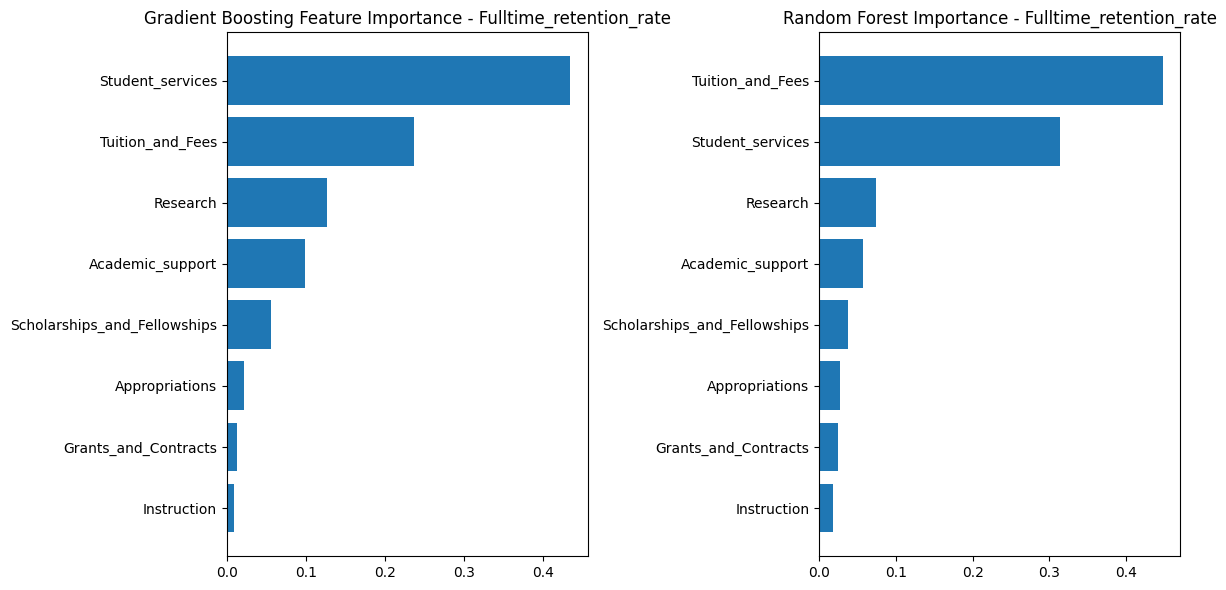

In [46]:

Ensemble_df = df_FY_All[['institution_name','year','Fulltime_retention_rate','Four_year_graduation_rate','Instruction','Research','Academic_support','Scholarships_and_Fellowships','Student_services','Grants_and_Contracts','Appropriations','Sales_and_Services','Tuition_and_Fees']]

# All features which will be used to create the Gradient Boosting and Random Forest models
features = ['Instruction', 'Research', 'Academic_support', 'Student_services','Grants_and_Contracts', 'Appropriations', 'Tuition_and_Fees','Scholarships_and_Fellowships']

# All target variables which will be used in the analysis to create the Gradient Boosting and Random Forest models
targets = ['Fulltime_retention_rate', 'Four_year_graduation_rate']

# Standardize features for ease of comparison or feature importance
scaler = StandardScaler()
X = scaler.fit_transform(Ensemble_df[features])
X = pd.DataFrame(X, columns=features)

# Dictionary to put the results in 
results = {}

# Function which in takes the features, target variables and model (either random forest or Gradient boosting) as parameters
def train_evaluate_model(X, y, model_type):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    if model_type == 'gbm':
        #creating a parameter grid for hyperparameter tuning to Gradient Boosting model
        param_grid = {
            'n_estimators': [100, 200],
            'max_depth': [3, 4, 5],
            'learning_rate': [0.01, 0.1]
        }

        #running the Gradient Boosting model
        model = GradientBoostingRegressor(random_state=42)
    else:
        #creating a parameter grid for hyperparameter tuning to random forest model
        param_grid = {
            'n_estimators': [100, 200],
            'max_depth': [3, 4, 5],
            'min_samples_split': [2, 5]
        }
        #running the random forest model
        model = RandomForestRegressor(random_state=42)

    #executing grid search view for each appropriate model and fitting into grid search 
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='r2')
    grid_search.fit(X_train, y_train)
    
    #based on tuning, optimal model for each algorithm is produced and predictions from the test variables are made
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    
    #Optimal combinations of revenue streams and funding combinations for each appropriate model
    return {
        'model': best_model,
        'best_params': grid_search.best_params_,
        'r2_score': r2_score(y_test, y_pred),
        'rmse': np.sqrt(mean_squared_error(y_test, y_pred)),
        'feature_importance': dict(zip(features, best_model.feature_importances_))
    }

# Training both the Random Forest and Gradient Boosting models
for target in targets:
    results[target] = {
        'gbm': train_evaluate_model(X, Ensemble_df[target], 'gbm'),
        'rf': train_evaluate_model(X, Ensemble_df[target], 'rf')
    }

# This function creates plots of the most important features (those that produce most accurate model) for each respective algorithm
def plot_feature_importance(results, target):
    plt.figure(figsize=(12, 6))
    
    # Importance bar plot for gradient boosting algorithm
    importance_gradient_boosting = pd.DataFrame(results[target]['gbm']['feature_importance'].items(), columns=['Feature', 'Importance'])
    importance_gradient_boosting= importance_gradient_boosting.sort_values('Importance', ascending=True)
    
    plt.subplot(1, 2, 1)
    plt.barh(importance_gradient_boosting['Feature'],  importance_gradient_boosting['Importance'])
    plt.title(f'Gradient Boosting Feature Importance - {target}')
    
    # Importance bar plot for random forest algorithm
    importance_random_forest = pd.DataFrame(results[target]['rf']['feature_importance'].items(), columns=['Feature', 'Importance'])
    importance_random_forest = importance_random_forest.sort_values('Importance', ascending=True)
    
    plt.subplot(1, 2, 2)
    plt.barh(importance_random_forest['Feature'], importance_random_forest['Importance'])
    plt.title(f'Random Forest Importance - {target}')
    
    plt.tight_layout()
    plt.show()



 #Plot the feature importance plot for retention rate
plot_feature_importance(results, 'Fulltime_retention_rate')



**Ensemble Algorithms (Graduation Rate)**

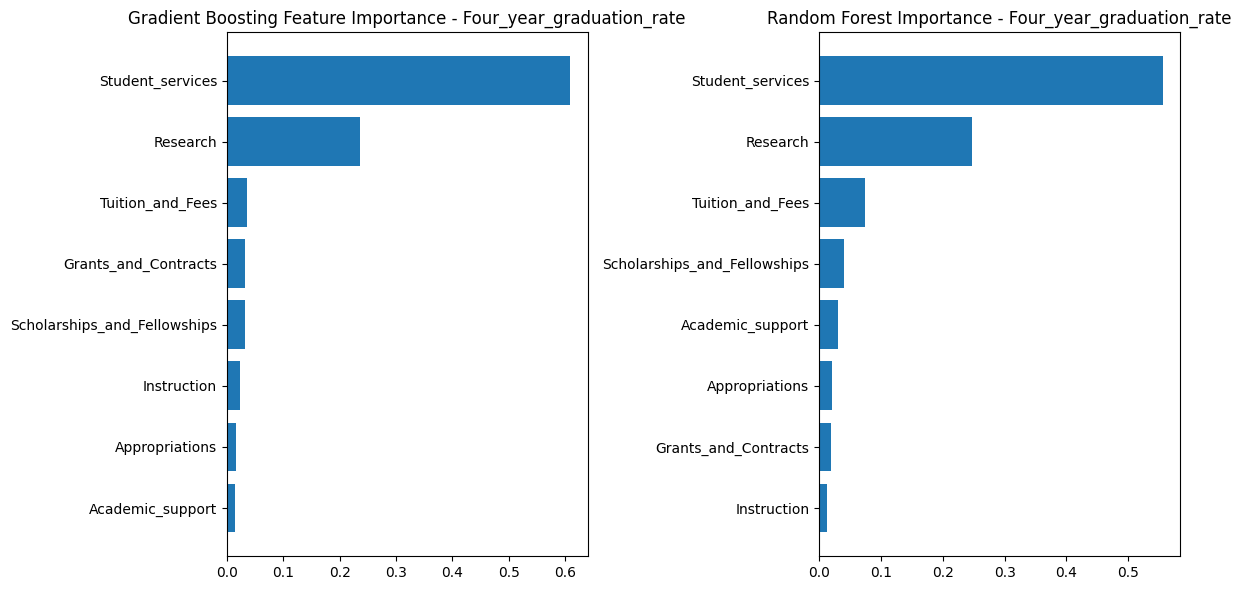

In [47]:

Ensemble_df = df_FY_All[['institution_name','year','Fulltime_retention_rate','Four_year_graduation_rate','Instruction','Research','Academic_support','Scholarships_and_Fellowships','Student_services','Grants_and_Contracts','Appropriations','Sales_and_Services','Tuition_and_Fees']]

# All features which will be used to create the Gradient Boosting and Random Forest models
features = ['Instruction', 'Research', 'Academic_support', 'Student_services','Grants_and_Contracts', 'Appropriations', 'Tuition_and_Fees','Scholarships_and_Fellowships']

# All target variables which will be used in the analysis to create the Gradient Boosting and Random Forest models
targets = ['Fulltime_retention_rate', 'Four_year_graduation_rate']

# Standardize features for ease of comparison or feature importance
scaler = StandardScaler()
X = scaler.fit_transform(Ensemble_df[features])
X = pd.DataFrame(X, columns=features)

# Dictionary to put the results in 
results = {}

# Function which in takes the features, target variables and model (either random forest or Gradient boosting) as parameters
def train_evaluate_model(X, y, model_type):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    if model_type == 'gbm':
        #creating a parameter grid for hyperparameter tuning to Gradient Boosting model
        param_grid = {
            'n_estimators': [100, 200],
            'max_depth': [3, 4, 5],
            'learning_rate': [0.01, 0.1]
        }

        #running the Gradient Boosting model
        model = GradientBoostingRegressor(random_state=42)
    else:
        #creating a parameter grid for hyperparameter tuning to random forest model
        param_grid = {
            'n_estimators': [100, 200],
            'max_depth': [3, 4, 5],
            'min_samples_split': [2, 5]
        }
        #running the random forest model
        model = RandomForestRegressor(random_state=42)

    #executing grid search view for each appropriate model and fitting into grid search 
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='r2')
    grid_search.fit(X_train, y_train)
    
    #based on tuning, optimal model for each algorithm is produced and predictions from the test variables are made
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    
    #Optimal combinations of revenue streams and funding combinations for each appropriate model
    return {
        'model': best_model,
        'best_params': grid_search.best_params_,
        'r2_score': r2_score(y_test, y_pred),
        'rmse': np.sqrt(mean_squared_error(y_test, y_pred)),
        'feature_importance': dict(zip(features, best_model.feature_importances_))
    }

# Training both the Random Forest and Gradient Boosting models
for target in targets:
    results[target] = {
        'gbm': train_evaluate_model(X, Ensemble_df[target], 'gbm'),
        'rf': train_evaluate_model(X, Ensemble_df[target], 'rf')
    }

# This function creates plots of the most important features (those that produce most accurate model) for each respective algorithm
def plot_feature_importance(results, target):
    plt.figure(figsize=(12, 6))
    
    # Importance bar plot for gradient boosting algorithm
    importance_gradient_boosting = pd.DataFrame(results[target]['gbm']['feature_importance'].items(), columns=['Feature', 'Importance'])
    importance_gradient_boosting= importance_gradient_boosting.sort_values('Importance', ascending=True)
    
    plt.subplot(1, 2, 1)
    plt.barh(importance_gradient_boosting['Feature'],  importance_gradient_boosting['Importance'])
    plt.title(f'Gradient Boosting Feature Importance - {target}')
    
    # Importance bar plot for random forest algorithm
    importance_random_forest = pd.DataFrame(results[target]['rf']['feature_importance'].items(), columns=['Feature', 'Importance'])
    importance_random_forest = importance_random_forest.sort_values('Importance', ascending=True)
    
    plt.subplot(1, 2, 2)
    plt.barh(importance_random_forest['Feature'], importance_random_forest['Importance'])
    plt.title(f'Random Forest Importance - {target}')
    
    plt.tight_layout()
    plt.show()

#Plot the feature importance plot for graduation rate
plot_feature_importance(results, 'Four_year_graduation_rate')

**SVR Algorithm: Feature Combination Predictors (Retention Rate)**

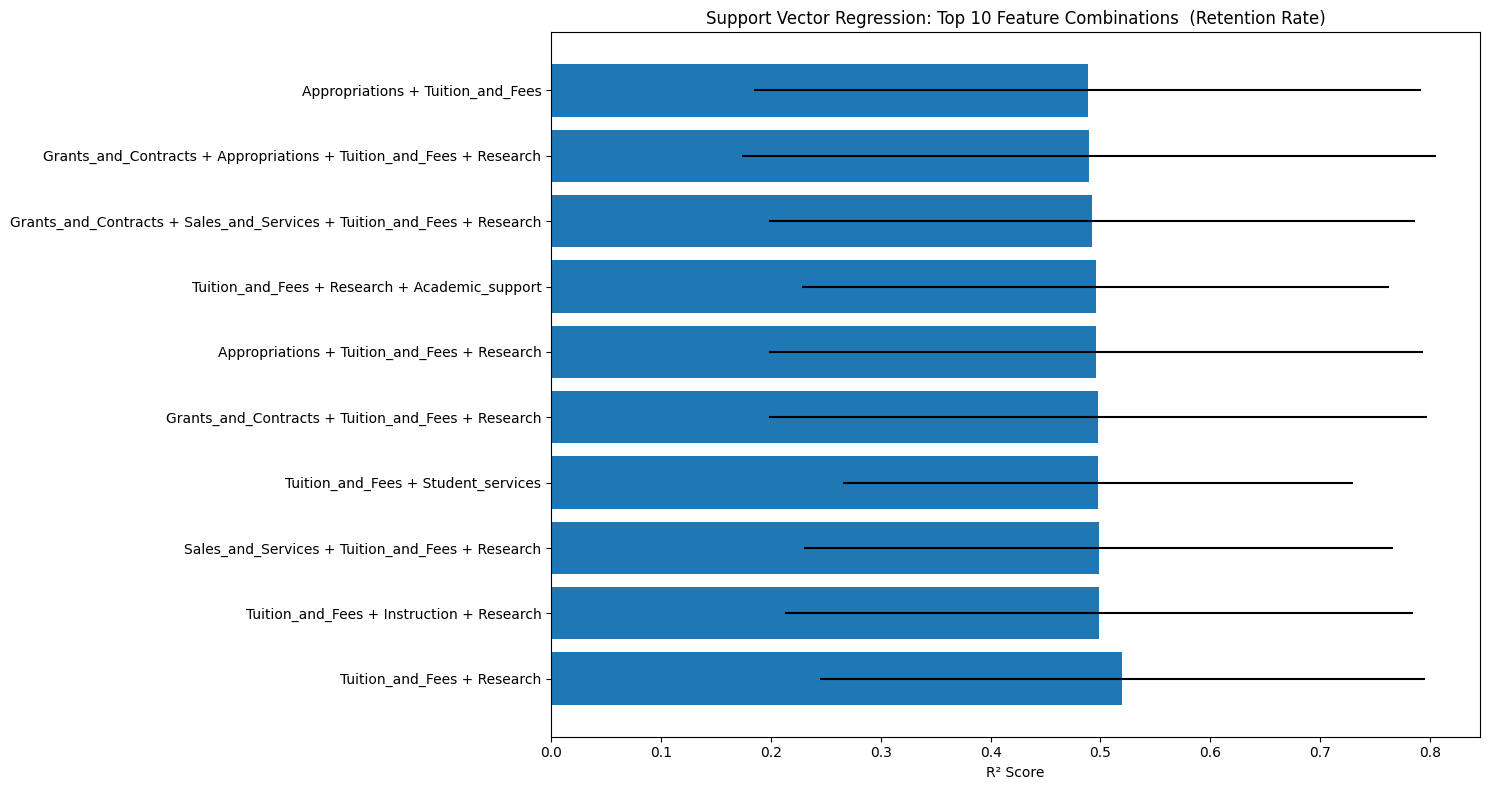

In [48]:
SVR_df = df_FY_All[['Fulltime_retention_rate','Four_year_graduation_rate','Instruction','Research','Academic_support','Scholarships_and_Fellowships','Student_services','Grants_and_Contracts','Appropriations','Sales_and_Services','Tuition_and_Fees']]
revenue_stream_features = ['Grants_and_Contracts','Appropriations','Sales_and_Services','Tuition_and_Fees']
funding_allocation_features = ['Instruction','Research','Academic_support','Scholarships_and_Fellowships','Student_services']


def Feature_Combination_Evaluation(revenue_features, funding_features,target, max_features=4):
    
        features = revenue_features + funding_features
        results = {}
        
        for r in range(2, max_features + 1):
            for combo in combinations(features, r):
                X = SVR_df[list(combo)]
                y = SVR_df[target]
                
                # Scale features
                scaler = StandardScaler()
                X_scaled = scaler.fit_transform(X)
                
                # Train SVR model
                model = SVR(kernel='rbf')
                scores = cross_val_score(model, X_scaled, y, cv=5, scoring='r2')
                
                results[combo] = {
                    'mean_r2': scores.mean(),
                    'std_r2': scores.std(),
                    'feature_count': len(combo)
                }
        
        return results

#plotting the top feature combinations
def Top_Combinations_Plot(results, title, top_n=10):
        # Sort combinations by performance
        sorted_results = sorted(results.items(), 
                              key=lambda x: x[1]['mean_r2'], 
                              reverse=True)[:top_n]
        
        plt.figure(figsize=(15, 8))
        
        combinations = [' + '.join(combo[0]) for combo in sorted_results]
        scores = [result[1]['mean_r2'] for result in sorted_results]
        errors = [result[1]['std_r2'] for result in sorted_results]
        
        plt.barh(range(len(combinations)), scores, xerr=errors)
        plt.yticks(range(len(combinations)), combinations)
        plt.xlabel('R² Score')
        plt.title(f'Support Vector Regression: Top {top_n} Feature Combinations  {title}')
        plt.tight_layout()
        plt.show()
        
      

# Evaluate feature combinations for retention
retention_results = Feature_Combination_Evaluation(revenue_stream_features,funding_allocation_features,'Fulltime_retention_rate')
Top_Combinations_Plot(retention_results,'(Retention Rate)')



**SVR Algorithm: Feature Combination Predictors (Graduation Rate)**

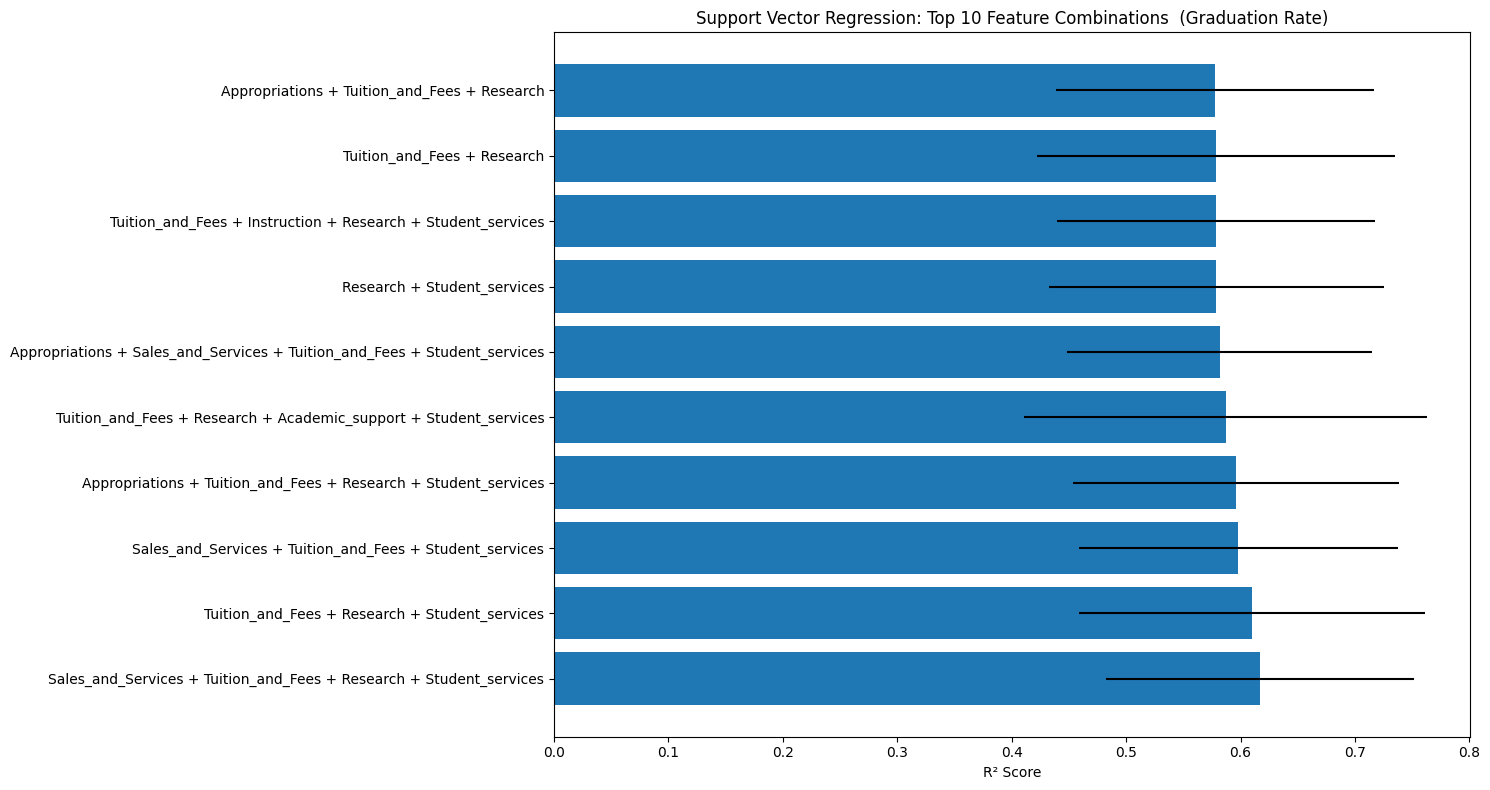

In [49]:
SVR_df = df_FY_All[['Fulltime_retention_rate','Four_year_graduation_rate','Instruction','Research','Academic_support','Scholarships_and_Fellowships','Student_services','Grants_and_Contracts','Appropriations','Sales_and_Services','Tuition_and_Fees']]
revenue_stream_features = ['Grants_and_Contracts','Appropriations','Sales_and_Services','Tuition_and_Fees']
funding_allocation_features = ['Instruction','Research','Academic_support','Scholarships_and_Fellowships','Student_services']


def Feature_Combination_Evaluation(revenue_features, funding_features,target, max_features=4):
    
        features = revenue_features + funding_features
        results = {}
        
        for r in range(2, max_features + 1):
            for combo in combinations(features, r):
                X = SVR_df[list(combo)]
                y = SVR_df[target]
                
                # Scale features
                scaler = StandardScaler()
                X_scaled = scaler.fit_transform(X)
                
                # Train SVR model
                model = SVR(kernel='rbf')
                scores = cross_val_score(model, X_scaled, y, cv=5, scoring='r2')
                
                results[combo] = {
                    'mean_r2': scores.mean(),
                    'std_r2': scores.std(),
                    'feature_count': len(combo)
                }
        
        return results

#plotting the top feature combinations
def Top_Combinations_Plot(results, title, top_n=10):
        # Sort combinations by performance
        sorted_results = sorted(results.items(), 
                              key=lambda x: x[1]['mean_r2'], 
                              reverse=True)[:top_n]
        
        plt.figure(figsize=(15, 8))
        
        combinations = [' + '.join(combo[0]) for combo in sorted_results]
        scores = [result[1]['mean_r2'] for result in sorted_results]
        errors = [result[1]['std_r2'] for result in sorted_results]
        
        plt.barh(range(len(combinations)), scores, xerr=errors)
        plt.yticks(range(len(combinations)), combinations)
        plt.xlabel('R² Score')
        plt.title(f'Support Vector Regression: Top {top_n} Feature Combinations  {title}')
        plt.tight_layout()
        plt.show()

# Evaluate feature combinations for graduation
graduation_results = Feature_Combination_Evaluation(revenue_stream_features,funding_allocation_features,'Four_year_graduation_rate')
Top_Combinations_Plot(graduation_results, '(Graduation Rate)')